FileName = ImgSegmentation_U-Net.ipynb. The code here shows how to use the U-Net Architecture for Semancic Img Segmentation using TF / Keras  

The dataset used comes from he Oxford IIT Pets data set. The original code was located at

    /drv3/hm3/code/python/keras.3.02/

The code was originally run in a Virtual Env under Python 3.10.12, with TF/Keras 2.15
The data is supposed to be obtain as

!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

But instead I visited Kaggle, obtained the dataset and stored it at 

/dev3/hm3/Data/ImgData/Oxford_iit_pets

AS of Feb 2025, I am running TF/Keras 2.18 under a virtEnv named tf2.18 


In [1]:
# get the libraries ready
import os
import matplotlib.pyplot as plt
import matplotlib
import random
import numpy as np

import shutil, pathlib

import matplotlib.image as mpimg
from PIL import Image 

# APIs to plot a keras model using keras.utils.plot_model()
# besides installing graphviz via pip install graphviz,
# I also had to install in Ubuntu via sudo apt install graphviz 
import pydot
import graphviz


import tensorflow as tf
import keras
from keras.utils import load_img, img_to_array
from keras.utils import array_to_img

from keras import layers

print("pydot version    = ", pydot.__version__)
print("graphviz version = ", graphviz.__version__)
print(tf.__version__)
print(keras.__version__)
print(matplotlib.__version__)
print( tf.config.list_physical_devices('GPU') )

2024-02-14 19:26:13.406401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 19:26:13.406441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 19:26:13.407664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 19:26:13.413263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 19:26:13.934658: W tensorflow/compiler/tf2

pydot version    =  2.0.0
graphviz version =  0.20.1
2.15.0
2.15.0
3.8.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-14 19:26:14.719753: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-14 19:26:14.753567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-14 19:26:14.753765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:

dataDir = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/"
codeDir = "/drv3/hm3/code/python/tf2.18/tf2.18/local/ImgSegmentation/"
input_dir  = dataDir + "images/"   # contains the 7,394 images
target_dir = dataDir +  "annotations/trimaps/"

# there are 7390 files in input_img_paths
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])

# there are 7390 files in target_img_paths
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])



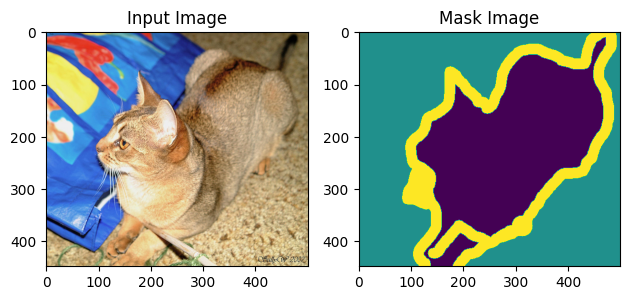

In [3]:
# image displayed is "Abyssinian_107.jpg" Image is of size 151 KBs

def process_mask( m ):
    mask = np.argmax(m, axis=-1)
    mask *= 127
    return mask

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2)
  
# Plot input Img 
input_img = load_img(input_img_paths[9])
axis[0].imshow(input_img)
axis[0].set_title("Input Image")
  
# Plot mask Img  
mask_img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
axis[1].imshow( mask_img )
axis[1].set_title("Mask Image")

# Combine imgs in a tight layout  
plt.tight_layout() 
plt.show()


In [4]:
""" Do not use this code anymore """
""" 
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

"""

' \ndef display_target(target_array):\n    normalized_array = (target_array.astype("uint8") - 1) * 127\n    plt.axis("off")\n    plt.imshow(normalized_array[:, :, 0])\n\nimg = img_to_array(load_img(target_paths[9], color_mode="grayscale"))\ndisplay_target(img)\n\n'

In [8]:
""" 
The images in the dataset have different shapes and sizes.
We must transform the images to a singe size, which here it is (128,128,RGB) . 

The function load_img(source, size) takes an image from source and
returns the image transformed to a new size using nearest image interpolation. 
"""

img_size = (128, 128)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

""" 
# resize images and masks
def resize( input_img, input_msk):
    input_image = tf.image.resize( input_image, img_size, method="nearest")
    input_mask = tf.image.resize( input_mask, img_size, method="nearest")
    return input_img, input_msk

# Augment data by flipping horizontally
def augment( input_img, input_msk) :
    if  tf.random.uniform(()) > 0.5:
        input_img = tf.image.flip_left_right(input_img)
        input_msk = tf.image.flip_left_right(input_msk)
    return input_img, input_msk

# Normalize (scale) the images
def normalize(input_img, input_msk) :
    input_img = tf.cast(input_img, tf.float32) / 255.0
    input_mask -= 1
    return input_img, input_msk


# perform img augmentation on the training dataset
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

# do NOT perform img augmentation on the test dataset
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

""" 


def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])


num_val_samples = 1000
# train_input_imgs and train_targets contain 6390 files 
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]

# val_input_imgs and val_targets contain 1000 files
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]


In [10]:
# verify data is ready

""" Do not run this code for now
target_img_file = train_targets[0]  # img.shape = (500,333), size = 
target_img = mpimg.imread( target_img_file)
print("target img shape = " , target_img.shape )

target_im_frame = Image.open( target_img_file)
np_frame = np.array( target_im_frame.getdata())
print("np shape = ", np_frame.shape)
np2_frame = np.reshape( np_frame, np_frame.shape) 
print("np2_frame.shape = ", np2_frame.shape )
#plt.imshow( target_img )

input_img_file = train_input_imgs[0]  # img.shape = (500,333), size = 
input_img = mpimg.imread( input_img_file)
print("input img shape = " , input_img.shape )

input_im_frame = Image.open( input_img_file)
np_frame = np.array( input_im_frame.getdata())
print("np shape = ", np_frame.shape)
np2_frame = np.reshape( np_frame, np_frame.shape) 
print("np2_frame.shape = ", np2_frame.shape )
#plt.imshow(input_img )

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2)
  
# Plot input Img 
axis[0].imshow(input_img)
axis[0].set_title("Input Img")
  
# For target Img 
axis[1].imshow(target_img)
axis[1].set_title("Target Img")

# Combine imgs in a tight layout  
plt.tight_layout() 
plt.show()

"""



' Do not run this code for now\ntarget_img_file = train_targets[0]  # img.shape = (500,333), size = \ntarget_img = mpimg.imread( target_img_file)\nprint("target img shape = " , target_img.shape )\n\ntarget_im_frame = Image.open( target_img_file)\nnp_frame = np.array( target_im_frame.getdata())\nprint("np shape = ", np_frame.shape)\nnp2_frame = np.reshape( np_frame, np_frame.shape) \nprint("np2_frame.shape = ", np2_frame.shape )\n#plt.imshow( target_img )\n\ninput_img_file = train_input_imgs[0]  # img.shape = (500,333), size = \ninput_img = mpimg.imread( input_img_file)\nprint("input img shape = " , input_img.shape )\n\ninput_im_frame = Image.open( input_img_file)\nnp_frame = np.array( input_im_frame.getdata())\nprint("np shape = ", np_frame.shape)\nnp2_frame = np.reshape( np_frame, np_frame.shape) \nprint("np2_frame.shape = ", np2_frame.shape )\n#plt.imshow(input_img )\n\n# Initialise the subplot function using number of rows and columns\nfigure, axis = plt.subplots(1, 2)\n  \n# Plot i

In [11]:
# define a version of the U-Net model 

def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

def build_unet_model() :

 # inputs
   inputs = layers.Input(shape=(128,128,3))
   # encoder: downsample 1
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: upsample 6 
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model


unet_model = build_unet_model()

unet_model.summary()
# keras.utils.plot_model( unet_model, to_file="/drv3/hm3/code/python/keras.3.02/u-net-model.png" )

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

2024-02-14 19:36:11.012227: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-14 19:36:11.012423: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-14 19:36:11.012640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

                                                                                                  
 concatenate_2 (Concatenate  (None, 64, 64, 256)          0         ['conv2d_transpose_2[0][0]',  
 )                                                                   'conv2d_3[0][0]']            
                                                                                                  
 dropout_6 (Dropout)         (None, 64, 64, 256)          0         ['concatenate_2[0][0]']       
                                                                                                  
 conv2d_14 (Conv2D)          (None, 64, 64, 128)          295040    ['dropout_6[0][0]']           
                                                                                                  
 conv2d_15 (Conv2D)          (None, 64, 64, 128)          147584    ['conv2d_14[0][0]']           
                                                                                                  
 conv2d_tr

In [ ]:
# The unet_model takes 100% of the GPU and abut 80% of the GPU Memory   

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

callback_dir = codeDir + "/Playground/ImgSegmentation_U-Net.keras"

callbacks = [ keras.callbacks.ModelCheckpoint(callback_dir, save_best_only=True) ]

history = unet_model.fit(train_input_imgs, train_targets, verbose=0,
                    # epochs=50,
                    epochs=20,
                    callbacks=callbacks,
                    # batch_size=64,
                    batch_size=32,
                    validation_data=(val_input_imgs, val_targets))



2024-02-14 19:36:23.849757: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-14 19:36:24.102539: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-14 19:36:24.205484: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-14 19:36:24.761720: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-14 19:36:28.756676: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f070d144b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-14 19:36:28.756714: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, C

INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/ImgSegmentation_U-Net/assets


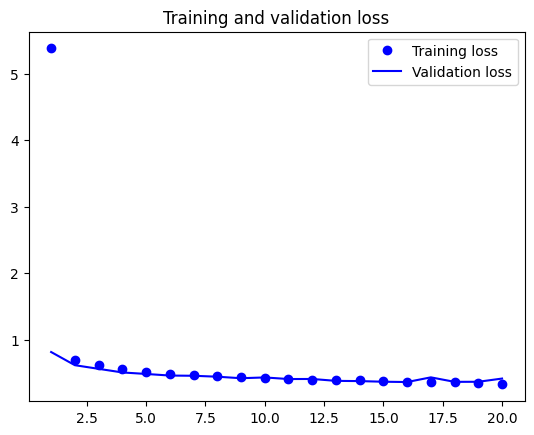

In [13]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [14]:
# define u-net as inception-like model 

# {1, 2, 3}
num_classes = 3

def get_inception_like_u_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
inception_like_u_model = get_inception_like_u_model(img_size, num_classes)
inception_like_u_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 64, 64, 32)           896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 32)           128       ['conv2d_19[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 64, 64, 32)           0         ['batch_normalization[0][0

In [21]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
inception_like_u_model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callback_dir = codeDir + "inception_like_u_model/"

callbacks = [
    keras.callbacks.ModelCheckpoint(callback_dir, save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 20

inception_like_u_net_Model_history = inception_like_u_model.fit( train_input_imgs, train_targets,
                                        verbose = 0, epochs=epochs, callbacks=callbacks,
                                        validation_data=(val_input_imgs, val_targets)
)

INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/inception_like_u_model/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/inception_like_u_model/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/inception_like_u_model/assets


INFO:tensorflow:Assets written to: /drv3/hm3/code/python/keras.3.02/inception_like_u_model/assets


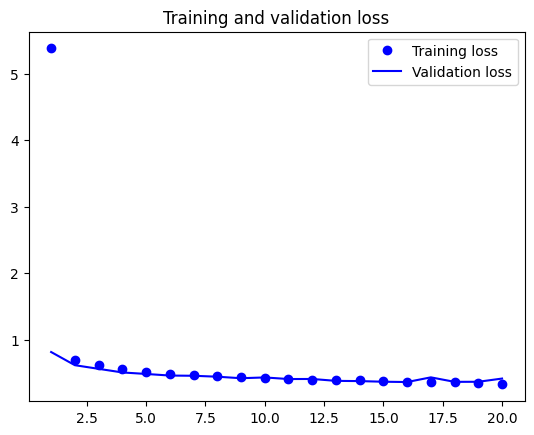

In [20]:
epochs = range(1, len(inception_like_u_net_Model_history.history["loss"]) + 1)
loss = inception_like_u_net_Model_history.history["loss"]
val_loss = inception_like_u_net_Model_history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [ ]:
""" 
The GPU card I was using (GeForce RTX 1060) has limited capacity to process this segmentation task under the fit parameters being used.
By reducing the batch_size from 64 to just 8, the processing could finish in 60+ minutes.
I increased the batch_size = 16. The processing does not crash but it takes too long to process.

Jasiu said he was using for his segmentation app a batch size of 2. but I also suspect the processing will take long... 
There was an error msg that suggested using  "export TF_GPU_ALLOCATOR=cuda_malloc_async " so I did that in /etc/profile

On 20231006 I installed a new RTX 3060 GPU card with 3584 GPUs and 12 GB of memory. The first thing to note is that the fit operation does not crash with
batch_size=64. The fit operation took 29 minutes and 21 secs and the results are similar to the results in the book. 
"""


model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callback_dir = "/drv3/hm3/code/python/tf/keras/Playground/tmp/chap09/oxford_segmentation/"

callbacks = [
    keras.callbacks.ModelCheckpoint(callback_dir, save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets, verbose=0,
                    epochs=50,
                    # epochs=20,
                    callbacks=callbacks,
                    batch_size=64,
                    # batch_size=32,
                    validation_data=(val_input_imgs, val_targets))

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [ ]:

model = keras.models.load_model(callback_dir)

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)